In [2]:
# Success/Failure 세기
from pathlib import Path
import pandas as pd
import os

# Simulate reading multiple files by reusing the same file for demonstration
folder_path = Path('./DS_experiment_data/ALL_beta')
csv_files = folder_path.glob('*.csv')

# Initialize counters
success_count = 0
failure_count = 0
distance_v_diff_count = [[0,0,0] for _ in range(3)]
MV_speed_count = [0,0,0]

# Process each CSV file
for file_path in csv_files:
    # Read the last row of the current CSV file
    
    
    file_name = os.path.basename(file_path)
    file_name = file_name.replace('.csv','')
    parts = file_name.split('_')
    data = pd.read_csv(file_path)
    # display(data.head())
    distance_v_diff_count[int(parts[1])//10-1][int(parts[2])//10-1]+=1
    # Extract MV and FV y-coordinates from the last row
    y_mv = data['y_MV'].iloc[-1]
    y_fv = data['y_FV'].iloc[-1]
    MV_speed_count[int(parts[3])//10-4]+=1
    # Determine success or failure
    if y_mv < y_fv:
        success_count += 1
    else:
        failure_count += 1
print('Vdiff: 10, 20, 30')
for i, col in enumerate(distance_v_diff_count):
    print((i+1)*10,'m',col)
print(MV_speed_count)
# Display the counts
(success_count, failure_count)



Vdiff: 10, 20, 30
10 m [45, 31, 34]
20 m [40, 31, 36]
30 m [40, 40, 43]
[108, 105, 127]


(226, 114)

In [9]:
# FuncAnimation
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.animation import FuncAnimation
from pathlib import Path
import os


def get_vehicle_corners(x, y, yaw, length, width):
    # Calculate rear center position
    # rear_x = x - (length / 2) * np.cos(np.radians(yaw))
    # rear_y = y - (length / 2) * np.sin(np.radians(yaw))
    
    # Calculate corner points
    corners_x = [x + (length / 2) * np.cos(np.radians(yaw)) - (width / 2) * np.sin(np.radians(yaw)), # Front Right
                 x + (length / 2) * np.cos(np.radians(yaw)) + (width / 2) * np.sin(np.radians(yaw)), # Front Left
                 x - (length / 2) * np.cos(np.radians(yaw)) + (width / 2) * np.sin(np.radians(yaw)), # Rear Left
                 x - (length / 2) * np.cos(np.radians(yaw)) - (width / 2) * np.sin(np.radians(yaw)), # Rear Right
                 x + (length / 2) * np.cos(np.radians(yaw)) - (width / 2) * np.sin(np.radians(yaw))]
    
    corners_y = [y + (length / 2) * np.sin(np.radians(yaw)) + (width / 2) * np.cos(np.radians(yaw)), # Front Right
                 y + (length / 2) * np.sin(np.radians(yaw)) - (width / 2) * np.cos(np.radians(yaw)), # Front Left
                 y - (length / 2) * np.sin(np.radians(yaw)) - (width / 2) * np.cos(np.radians(yaw)), # Rear Left
                 y - (length / 2) * np.sin(np.radians(yaw)) + (width / 2) * np.cos(np.radians(yaw)), # Rear Right
                 y + (length / 2) * np.sin(np.radians(yaw)) + (width / 2) * np.cos(np.radians(yaw))]
    
    return corners_x, corners_y

# Animation function
def animate(i):
    global First_crossed
    ax.clear()
    ax2.clear()

    # Flip the x and y axis limits
    ax.set_ylim(min(min(data.x_FV), min(data.x_MV)) - 10, max(max(data.x_FV), max(data.x_MV)) + 10)
    ax.set_xlim(min(min(data.y_FV), min(data.y_MV)) - 10, max(max(data.y_FV), max(data.y_MV)) + 10)
    
    # Draw lanes as horizontal dashed lines instead of vertical
    for lane_y in [9.9, 13.3, 16.8]:
        ax.axhline(y=lane_y, color='gray', linestyle='--')
    
    # Get vehicle corners for each car and flip x and y coordinates for plotting
    if 'Yaw_FV' in data.columns:
        corners_x_FV, corners_y_FV = get_vehicle_corners(data['x_FV'].iloc[i], data['y_FV'].iloc[i], data['Yaw_FV'].iloc[i], vehicle_length, vehicle_width)
    else:
        corners_x_FV, corners_y_FV = get_vehicle_corners(data['x_FV'].iloc[i], data['y_FV'].iloc[i], -90.29, vehicle_length, vehicle_width)
    corners_x_MV, corners_y_MV = get_vehicle_corners(data['x_MV'].iloc[i],data['y_MV'].iloc[i],  data['Yaw_MV'].iloc[i], vehicle_length, vehicle_width)
    if 'x_LV' in data.columns and 'y_LV' in data.columns:
        corners_x_LV, corners_y_LV = get_vehicle_corners(data['x_LV'].iloc[i],data['y_LV'].iloc[i],  -90.29, vehicle_length, vehicle_width)
        ax.plot(corners_y_LV, corners_x_LV, 'c')  # Flip x and y
    
    # Plot Front Vehicle (FV) and Main Vehicle (MV) with flipped axes
    ax.plot(corners_y_FV, corners_x_FV, 'r')  # Flip x and y
    ax.plot(corners_y_MV, corners_x_MV, 'b')  # Flip x and y
    
    ax.plot([-175, -169], [13.3, 16.8], color='black')
    
    ax.set_title(f"Time: {data['Time'].iloc[i]:.2f}")

    if First_crossed is None:
        for j in range(len(data)):
            corners_x_MV, _ = get_vehicle_corners(data['x_MV'].iloc[j], data['y_MV'].iloc[j], data['Yaw_MV'].iloc[j], vehicle_length, vehicle_width)
            # 전방 왼쪽 꼭지점은 corners_x_MV[1]을 사용하여 접근
            if corners_x_MV[1] < 13.3:
                First_crossed = data['Time'].iloc[j]
                break

    # 두 번째 그래프(Interacting possibility) 설정
    ax2.plot(data['Time'], data['Filtered_Interacting_possibility'], color='#FF8C00')
    if First_crossed is not None:
        ax2.axvline(x=First_crossed, color='blue', linestyle='--', linewidth=2)
    ax2.set_ylim(-0.1, 1.1)  # Interacting possibility의 범위 설정
    ax2.set_xlim(data['Time'].iloc[0]-1, data['Time'].iloc[-1]+1)

    # LeftBlinker_MV가 True인 지점 표시
    blinker_on_data = data[data['LeftBlinker_MV']]
    for time in blinker_on_data['Time']:
        ax2.axvline(x=time, color='lightgreen', alpha=0.5)
    
    # 현재 시점 표시
    current_time = data['Time'].iloc[i]
    ax2.axvline(x=current_time, color='black')

# Define vehicle dimensions
vehicle_length = 4.18  # meters
vehicle_width = 1.99  # meters

for i in range(1,3):

    folder_path = Path('./DS_experiment_data/Exp'+str(i)+'/')
    csv_files = folder_path.glob('*.csv')

    for file_path in csv_files:
        SUCCESS = None
        First_crossed = None
        # Read the last row of the current CSV file
        data = pd.read_csv(file_path)

        # Filter possibility
        data['Filtered_Interacting_possibility'] = data['Interacting possibility'].copy()
        data.loc[~((data['x_MV'] > 13.3) & (data['gap_btw_MV'] > -vehicle_length)), 'Filtered_Interacting_possibility'] = np.nan

        if data['y_MV'].iloc[-1] < data['y_FV'].iloc[-1]:
            SUCCESS = True
        else:
            SUCCESS = False

        file_name = os.path.basename(file_path)
        file_name = file_name.replace('.csv','')
        # Setup figure and axis
        fig, axs = plt.subplots(2,1,figsize=(4*(max(max(data.y_FV), max(data.y_MV)) + 10-min(min(data.y_FV), min(data.y_MV)) + 10)/(max(max(data.x_FV), max(data.x_MV)) + 10 - min(min(data.x_FV), min(data.x_MV)) + 10), 8))
        ax = axs[0]
        ax2 = axs[1]

        # Creating animation
        ani = FuncAnimation(fig, animate, frames=len(data), interval=50, repeat=False)
        if SUCCESS:
            ani.save('./DS_experiment_data/Exp'+str(i)+'/'+file_name+'_success.gif', writer='imagemagick', fps=20)
        else:
            ani.save('./DS_experiment_data/Exp'+str(i)+'/'+file_name+'_failure.gif', writer='imagemagick', fps=20)
        print(file_path,'DONE')
        plt.close()  # Prevent extra static plot from displaying
        break
    


DS_experiment_data\Exp1\10_10_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp2\10_10_40_merging_scenario_data.csv DONE


C:\Users\User\AppData\Local\Temp\ipykernel_43544\2054341829.py:37: RuntimeWarning: divide by zero encountered in divide
  TTC = D / S  # TTC 계산


                              BetaModel Results                               
Dep. Variable:                      p   Log-Likelihood:                 24.844
Model:                      BetaModel   AIC:                            -41.69
Method:            Maximum Likelihood   BIC:                            -40.90
Date:                Thu, 11 Apr 2024                                         
Time:                        18:09:40                                         
No. Observations:                   9                                         
Df Residuals:                       5                                         
Df Model:                           2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2382      0.627     -0.380      0.704      -1.466       0.990
distance       0.2436      0.029      8.385      0.0

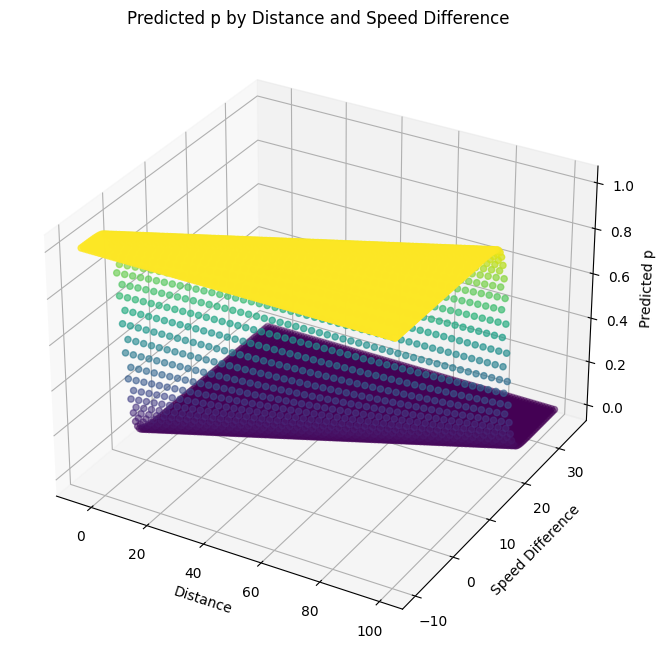

In [1]:
# Beta regression

import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.othermod.betareg import BetaModel
import matplotlib.pyplot as plt

distance = np.array([20, 20, 20, 30, 30, 30, 40, 40, 40])
speed_diff = np.array([20, 30, 40, 20, 30, 40, 20, 30, 40]) / 3.6  # 변환된 속도 차이
p = 1 - np.array([0.9125, 1.0, 1.0, 0.3875, 0.975, 1.0, 0.0875, 0.5625, 1.0])  # 이벤트가 발생하지 않을 확률
p_adjusted = np.clip(p, 0.001, 0.999)
# p_adjusted = np.clip(p,(0.5)/len(p),(1*len(p)-1+0.5)/len(p))

# Preparing the dataset
df = pd.DataFrame({'distance': distance, 'speed_diff': speed_diff, 'TTC': distance/speed_diff,'p': p_adjusted})

X = df[['distance', 'speed_diff']]
# X = df[['TTC']]
X = sm.add_constant(X)  # Adds a constant term to the predictor

y = df['p']
# Initialize and fit the beta regression model
model = BetaModel(endog=y, exog=X)
results = model.fit()
distance_Test = np.array([10,20,30,20,0])
speed_diff_Test = np.array([0.1,-10,-10,-20,-3])
TTC_test = distance_Test/speed_diff_Test
X_test = np.column_stack((np.ones(distance_Test.size),distance_Test.ravel(),speed_diff_Test.ravel()))

# 격자 생성을 위한 distance와 speed_diff의 범위 정의
distance_range = np.linspace(-5, 100, 100)
speed_diff_range = np.linspace(-10, 35, 100)

# 격자 생성
D, S = np.meshgrid(distance_range, speed_diff_range)
TTC = D / S  # TTC 계산
X_grid = np.column_stack((np.ones(D.size), D.ravel(), S.ravel()))  # 상수 항 포함
# X_grid = np.column_stack((np.ones(D.size), TTC.ravel()))

# 모델을 사용하여 격자 위의 지점들에 대한 p 예측
p_predicted = results.predict(X_grid)

# 3D 그래프 준비
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 예측된 p 값을 사용하여 3D 플롯 그리기
ax.scatter(D, S, p_predicted, c=p_predicted, cmap='viridis', marker='o')

ax.set_xlabel('Distance')
ax.set_ylabel('Speed Difference')
ax.set_zlabel('Predicted p')
plt.title('Predicted p by Distance and Speed Difference')
print(results.summary())
print(results.predict(X_test))
plt.show()

In [225]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              BetaModel Results                               
==============================================================================
Dep. Variable:                      p   Log-Likelihood:                 24.844
Model:                      BetaModel   AIC:                            -41.69
Method:            Maximum Likelihood   BIC:                            -40.90
Date:                Thu, 04 Apr 2024                                         
Time:                        22:17:40                                         
No. Observations:                   9                                         
Df Residuals:                       5                                         
Df Model:                           2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2382      0.627     -0.380      0.704      -1.466       0.990
distance       0.2436      0.029      8.385      0.000       0.187       0.300
speed_diff    -1.2087      0.118    -10.248      0.000      -1.440      -0.977
precision      4.3205      0.557      7.754      0.000       3.228       5.413
==============================================================================
"""

In [3]:
# imageio
# gif 저장
import imageio

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import os
import gc


def get_vehicle_corners(x, y, yaw, length, width):
    # Calculate rear center position
    # rear_x = x - (length / 2) * np.cos(np.radians(yaw))
    # rear_y = y - (length / 2) * np.sin(np.radians(yaw))
    
    # Calculate corner points
    corners_x = [x + (length / 2) * np.cos(np.radians(yaw)) - (width / 2) * np.sin(np.radians(yaw)), # Front Right
                 x + (length / 2) * np.cos(np.radians(yaw)) + (width / 2) * np.sin(np.radians(yaw)), # Front Left
                 x - (length / 2) * np.cos(np.radians(yaw)) + (width / 2) * np.sin(np.radians(yaw)), # Rear Left
                 x - (length / 2) * np.cos(np.radians(yaw)) - (width / 2) * np.sin(np.radians(yaw)), # Rear Right
                 x + (length / 2) * np.cos(np.radians(yaw)) - (width / 2) * np.sin(np.radians(yaw))]
    
    corners_y = [y + (length / 2) * np.sin(np.radians(yaw)) + (width / 2) * np.cos(np.radians(yaw)), # Front Right
                 y + (length / 2) * np.sin(np.radians(yaw)) - (width / 2) * np.cos(np.radians(yaw)), # Front Left
                 y - (length / 2) * np.sin(np.radians(yaw)) - (width / 2) * np.cos(np.radians(yaw)), # Rear Left
                 y - (length / 2) * np.sin(np.radians(yaw)) + (width / 2) * np.cos(np.radians(yaw)), # Rear Right
                 y + (length / 2) * np.sin(np.radians(yaw)) + (width / 2) * np.cos(np.radians(yaw))]
    
    return corners_x, corners_y

# Animation function
def animate(i):
    global First_crossed
    ax.clear()
    ax2.clear()

    # Flip the x and y axis limits
    ax.set_ylim(min(min(data.x_FV), min(data.x_MV)) - 10, max(max(data.x_FV), max(data.x_MV)) + 10)
    ax.set_xlim(min(min(data.y_FV), min(data.y_MV)) - 10, max(max(data.y_FV), max(data.y_MV)) + 10)
    
    # Draw lanes as horizontal dashed lines instead of vertical
    for lane_y in [9.9, 13.3, 16.8]:
        ax.axhline(y=lane_y, color='gray', linestyle='--')
    
    # Get vehicle corners for each car and flip x and y coordinates for plotting
    if 'Yaw_FV' in data.columns:
        corners_x_FV, corners_y_FV = get_vehicle_corners(data['x_FV'].iloc[i], data['y_FV'].iloc[i], data['Yaw_FV'].iloc[i], vehicle_length, vehicle_width)
    else:
        corners_x_FV, corners_y_FV = get_vehicle_corners(data['x_FV'].iloc[i], data['y_FV'].iloc[i], -90.29, vehicle_length, vehicle_width)
    corners_x_MV, corners_y_MV = get_vehicle_corners(data['x_MV'].iloc[i],data['y_MV'].iloc[i],  data['Yaw_MV'].iloc[i], vehicle_length, vehicle_width)
    if 'x_LV' in data.columns and 'y_LV' in data.columns:
        corners_x_LV, corners_y_LV = get_vehicle_corners(data['x_LV'].iloc[i],data['y_LV'].iloc[i],  -90.29, vehicle_length, vehicle_width)
        ax.plot(corners_y_LV, corners_x_LV, 'c')  # Flip x and y
    
    # Plot Front Vehicle (FV) and Main Vehicle (MV) with flipped axes
    ax.plot(corners_y_FV, corners_x_FV, 'r')  # Flip x and y
    ax.plot(corners_y_MV, corners_x_MV, 'b')  # Flip x and y
    
    ax.plot([-175, -169], [13.3, 16.8], color='black')
    
    ax.set_title(f"Time: {data['Time'].iloc[i]:.2f}")

    if First_crossed is None:
        for j in range(len(data)):
            corners_x_MV, _ = get_vehicle_corners(data['x_MV'].iloc[j], data['y_MV'].iloc[j], data['Yaw_MV'].iloc[j], vehicle_length, vehicle_width)
            # 전방 왼쪽 꼭지점은 corners_x_MV[1]을 사용하여 접근
            if corners_x_MV[1] < 13.3:
                First_crossed = data['Time'].iloc[j]
                break

    # 두 번째 그래프(Interacting possibility) 설정
    ax2.plot(data['Time'], data['Filtered_Interacting_possibility'], color='#FF8C00')
    if First_crossed is not None:
        ax2.axvline(x=First_crossed, color='blue', linestyle='--', linewidth=2)
    ax2.set_ylim(-0.1, 1.1)  # Interacting possibility의 범위 설정
    ax2.set_xlim(data['Time'].iloc[0]-1, data['Time'].iloc[-1]+1)

    # LeftBlinker_MV가 True인 지점 표시
    blinker_on_data = data[data['LeftBlinker_MV']]
    for time in blinker_on_data['Time']:
        ax2.axvline(x=time, color='lightgreen', alpha=0.5)
    
    # 현재 시점 표시
    current_time = data['Time'].iloc[i]
    ax2.axvline(x=current_time, color='black')

# Define vehicle dimensions
vehicle_length = 4.18  # meters
vehicle_width = 1.99  # meters

START = False
images = []
for i in range(1):

    folder_path = Path('./DS_experiment_data/Exp'+str(i)+'/')
    csv_files = folder_path.glob('*.csv')

    for file_path in csv_files:
        if file_path == Path('./DS_experiment_data/Exp0/Exp0_10_30_50_merging_scenario_data.csv'):
            print(file_path, 'Already Done')
            START = True
            continue
        if not START:
            print(file_path, 'Already Done')
            continue

        
        # Initialize
        data = pd.DataFrame()
        images.clear()
        gc.collect()
        SUCCESS = None
        First_crossed = None
        # Read the last row of the current CSV file
        data = pd.read_csv(file_path)

        # Possibility 치환, Filter possibility
        data['speed_diff'] = (data['speed_FV'] - data['speed_MV'])/3.6

        # 예측하고 결과 저장
        data['Interacting possibility'] = results.predict(sm.add_constant(data[['gap_btw_MV', 'speed_diff']]))
        data['Filtered_Interacting_possibility'] = data['Interacting possibility'].copy()
        data.loc[~((data['x_MV'] > 13.3) & (data['gap_btw_MV'] > -vehicle_length)), 'Filtered_Interacting_possibility'] = np.nan

        if data['y_MV'].iloc[-1] < data['y_FV'].iloc[-1]:
            SUCCESS = True
        else:
            SUCCESS = False

        file_name = os.path.basename(file_path)
        file_name = file_name.replace('.csv','')
        # Setup figure and axis
        
        width = 4*(max(max(data.y_FV), max(data.y_MV)) + 10-min(min(data.y_FV), min(data.y_MV)) + 10)/(max(max(data.x_FV), max(data.x_MV)) + 10 - min(min(data.x_FV), min(data.x_MV)) + 10)

        # Creating animation
        images = []
        for j in range(len(data)):
            fig, axs = plt.subplots(2,1,figsize=(width, 8))
            ax = axs[0]
            ax2 = axs[1]
            animate(j)
            fig.canvas.draw()
            image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
            image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            images.append(image)
            plt.close()
        if SUCCESS:
            imageio.mimsave('./DS_experiment_data/Exp'+str(i)+'/'+file_name+'_success.gif',images, writer='imagemagick' ,loop=0, fps=20)
        else:
            imageio.mimsave('./DS_experiment_data/Exp'+str(i)+'/'+file_name+'_failure.gif',images, writer='imagemagick', loop=0, fps=20)
        print(file_path,'DONE')
        plt.close()  # Prevent extra static plot from displaying



DS_experiment_data\Exp0\Exp0_10_10_60_merging_scenario_data.csv Already Done
DS_experiment_data\Exp0\Exp0_10_10_60_merging_scenario_data_1.csv Already Done
DS_experiment_data\Exp0\Exp0_10_10_60_merging_scenario_data_2.csv Already Done
DS_experiment_data\Exp0\Exp0_10_20_60_merging_scenario_data.csv Already Done
DS_experiment_data\Exp0\Exp0_10_30_40_merging_scenario_data.csv Already Done
DS_experiment_data\Exp0\Exp0_10_30_50_merging_scenario_data.csv Already Done
DS_experiment_data\Exp0\Exp0_10_30_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp0\Exp0_20_10_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp0\Exp0_20_10_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp0\Exp0_20_20_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp0\Exp0_20_20_50_merging_scenario_data_1.csv DONE
DS_experiment_data\Exp0\Exp0_20_20_50_merging_scenario_data_2.csv DONE
DS_experiment_data\Exp0\Exp0_20_20_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp0\Exp0_20_30_60_merging_s

In [3]:
from pathlib import Path
import os

# Initialize counters
success_count = [0]*17
failure_count = [0]*17


for i in range(17):

    folder_path = Path('./DS_experiment_data/Exp'+str(i)+'/')
    csv_files = folder_path.glob('*.gif')

    # Process each CSV file
    for file_path in csv_files:
        # Read the last row of the current CSV file
        file_name = os.path.basename(file_path)
        ans = file_name.split('_')[-1].split('.gif')[0]

        if ans == 'success':
            success_count[i]+=1
        elif ans == 'failure':
            failure_count[i]+=1
        else:
            print('AWwww!')


# Display the counts
display(success_count, failure_count)
print(sum(success_count), sum(failure_count))

[12, 14, 13, 11, 14, 16, 14, 15, 13, 15, 19, 12, 10, 12, 14, 12, 10]

[8, 6, 7, 9, 6, 4, 6, 5, 7, 5, 1, 8, 10, 8, 6, 8, 10]

226 114


In [6]:
# Change name(Exp 붙이기)
import os
for i in range(17):
    folder_path = Path('./DS_experiment_data/Exp'+str(i)+'/')
    for filename in os.listdir(folder_path):
        new_filename = f"Exp{str(i)}_{filename}"
        original_file = os.path.join(folder_path,filename)
        new_file = os.path.join(folder_path, new_filename)
        os.rename(original_file, new_file)
print('DONE')


DONE


In [7]:
# 값 변경하기 ※주의
for i in range(17):
# 모든 파일을 처리하고 결과를 리스트에 저장

    folder_path = Path('./DS_experiment_data/Exp'+str(i)+'/')
    csv_files = folder_path.glob('*.csv')

    for file_path in csv_files:
        # Initialize
        data = pd.DataFrame()

        data = pd.read_csv(file_path)
        X = pd.DataFrame()
        X['gap_btw_MV'] = data['gap_btw_MV']
        X['speed_diff']=data['speed_diff']/3.6
        # data['P_beta'] = results.predict(sm.add_constant(X[['gap_btw_MV', 'speed_diff']]))
        data['P_logistic'] = log_reg_sm.predict(sm.add_constant(data[['gap_btw_MV','speed_diff']]))
        data.to_csv(file_path,index=False)
        file_name = os.path.basename(file_path)
        file_name = file_name.replace('.csv','')
        # print(file_name,'DONE')
    print('Exp'+str(i),'Done')


Exp0 Done
Exp1 Done
Exp2 Done
Exp3 Done
Exp4 Done
Exp5 Done
Exp6 Done
Exp7 Done
Exp8 Done
Exp9 Done
Exp10 Done
Exp11 Done
Exp12 Done
Exp13 Done
Exp14 Done
Exp15 Done
Exp16 Done


In [36]:
# Copy each to ALL
import os
import shutil

base_path = './DS_experiment_data/'
all_folder_path = os.path.join(base_path, 'ALL_beta')
for i in range(17):
    exp_folder_path = os.path.join(base_path,f'Exp{i}')
    if os.path.exists(exp_folder_path):
        for filename in os.listdir(exp_folder_path):
            # gif 파일만 복사
            if filename.endswith('.gif'):
                # 원본 파일 경로를 구성합니다.
                original_file = os.path.join(exp_folder_path, filename)
                # 대상 파일 경로를 구성합니다. 이 경우 파일명 충돌을 방지하기 위해 원본 폴더명을 파일명에 추가할 수 있습니다.
                target_file = os.path.join(all_folder_path, f"{filename}")
                # 파일을 'ALL' 폴더로 복사합니다.
                shutil.copy(original_file, target_file)
    else:
        print('No folder',exp_folder_path)
    print(f'Exp{i}', 'Done')

Exp0 Done
Exp1 Done
Exp2 Done
Exp3 Done
Exp4 Done
Exp5 Done
Exp6 Done
Exp7 Done
Exp8 Done
Exp9 Done
Exp10 Done
Exp11 Done
Exp12 Done
Exp13 Done
Exp14 Done
Exp15 Done
Exp16 Done


In [1]:
# Count Interacting Case
import os
import shutil
import pandas as pd

base_path = './DS_experiment_data/ALL_beta/'

Interacting_Success = 0
Non_Interacting_Success = 0
Interacting_Failure = 0
Non_Interacting_Failure = 0

for filename in os.listdir(base_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(base_path, filename)
        df = pd.read_csv(file_path)
        
        # Interaction_probability가 0.5보다 큰 순간과 작은 순간이 모두 있는지 확인합니다.
        over_0_5 = df['P_logistic'] > 0.5
        under_0_5 = df['P_logistic'] < 0.5
        interacting = over_0_5.any() and under_0_5.any()
        
        # MV와 LV의 마지막 y 좌표를 비교합니다.
        MV_last_y = df['y_MV'].iloc[-1]
        FV_last_y = df['y_FV'].iloc[-1]
        MV_less_FV = MV_last_y < FV_last_y
        
        # 조건에 따라 파일을 분류합니다.
        if interacting and MV_less_FV:
            Interacting_Success += 1
        elif interacting and not MV_less_FV:
            Interacting_Failure += 1
        elif not interacting and MV_less_FV:
            Non_Interacting_Success +=1
        elif not interacting and not MV_less_FV:
            Non_Interacting_Failure +=1

print(Interacting_Success, Interacting_Failure, Non_Interacting_Success, Non_Interacting_Failure)
print(Interacting_Failure+Interacting_Success)


123 45 103 69
168


## Logistic Regression learning

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
import statsmodels.api as sm 
import matplotlib.pyplot as plt
import os
import seaborn as sns

vehicle_length = 4.18  # meters
vehicle_width = 1.99  # meters
def get_vehicle_corners(x, y, yaw, length, width):
    # Calculate rear center position
    # rear_x = x - (length / 2) * np.cos(np.radians(yaw))
    # rear_y = y - (length / 2) * np.sin(np.radians(yaw))
    
    # Calculate corner points
    corners_x = [x + (length / 2) * np.cos(np.radians(yaw)) - (width / 2) * np.sin(np.radians(yaw)), # Front Right
                 x + (length / 2) * np.cos(np.radians(yaw)) + (width / 2) * np.sin(np.radians(yaw)), # Front Left
                 x - (length / 2) * np.cos(np.radians(yaw)) + (width / 2) * np.sin(np.radians(yaw)), # Rear Left
                 x - (length / 2) * np.cos(np.radians(yaw)) - (width / 2) * np.sin(np.radians(yaw)), # Rear Right
                 x + (length / 2) * np.cos(np.radians(yaw)) - (width / 2) * np.sin(np.radians(yaw))]
    
    corners_y = [y + (length / 2) * np.sin(np.radians(yaw)) + (width / 2) * np.cos(np.radians(yaw)), # Front Right
                 y + (length / 2) * np.sin(np.radians(yaw)) - (width / 2) * np.cos(np.radians(yaw)), # Front Left
                 y - (length / 2) * np.sin(np.radians(yaw)) - (width / 2) * np.cos(np.radians(yaw)), # Rear Left
                 y - (length / 2) * np.sin(np.radians(yaw)) + (width / 2) * np.cos(np.radians(yaw)), # Rear Right
                 y + (length / 2) * np.sin(np.radians(yaw)) + (width / 2) * np.cos(np.radians(yaw))]
    
    return corners_x, corners_y

def process_file(file_path):

    # 파일에서 데이터를 읽어옵니다.
    data = pd.read_csv(file_path)

    # 첫 행의 Time 값을 기준으로 설정
    start_time = data.iloc[0]['Time']

    # 마지막 행의 y_MV가 y_FV보다 작으면 success, 크면 failure
    success = data.iloc[-1]['y_MV'] < data.iloc[-1]['y_FV']
    success = 1 if success else 0  # 성공은 1, 실패는 0으로 표현
    data['gap_btw_LV_MV'] = data['gap_btw_LV']-data['gap_btw_MV']-vehicle_length
    
    # LeftBlinker 활성화 여부 확인
    # 데이터에 'LeftBlinker' 열이 존재하고, 첫 행의 Time으로부터 1.3초 이내에 True인 경우를 찾습니다.
    left_blinker_active = 1 if ((data['Time'] <= start_time + 1.3) & (data['LeftBlinker_MV'])).any() else 0
    
    # 나머지 변수 준비
    # 초기값
    speed_MV = data.iloc[0]['speed_MV']
    speed_FV = data.iloc[0]['speed_FV']
    speed_diff = data.iloc[0]['speed_FV'] - data.iloc[0]['speed_MV']
    gap_btw_MV = data.iloc[0]['gap_btw_MV']
    gap_btw_LV = data.iloc[0]['gap_btw_LV']
    gap_btw_LV_MV = data.iloc[0]['gap_btw_LV_MV']

    # 평균값
    # First_crossed = None
    # for j in range(len(data)):
    #     corners_x_MV, _ = get_vehicle_corners(data['x_MV'].iloc[j], data['y_MV'].iloc[j], data['Yaw_MV'].iloc[j], vehicle_length, vehicle_width)
    #     # 전방 왼쪽 꼭지점은 corners_x_MV[1]을 사용하여 접근
    #     if corners_x_MV[1] < 13.3:
    #         First_crossed = data['Time'].iloc[j]
    #         break
    # condition = (data['gap_btw_MV'] > -vehicle_length/2) & (data['Time']<=First_crossed)
    # speed_MV = data.loc[condition, 'speed_MV'].mean()
    # speed_FV = data.loc[condition, 'speed_FV'].mean()
    # speed_diff = data.loc[condition, 'speed_diff'].mean()
    # gap_btw_MV = data.loc[condition,'gap_btw_MV'].mean()
    # gap_btw_LV = data.loc[condition,'gap_btw_LV'].mean()
    # gap_btw_LV_MV = data.loc[condition,'gap_btw_LV_MV'].mean()
    
    return [speed_MV, speed_FV, speed_diff, gap_btw_MV, gap_btw_LV,gap_btw_LV_MV, left_blinker_active, success]


In [3]:
folder_path = Path('./DS_experiment_data/ALL_beta/')  # 폴더 경로 지정
files = folder_path.glob('*.csv')

# 모든 파일을 처리하고 결과를 리스트에 저장

data_list = [process_file(file) for file in files]

# 리스트를 DataFrame으로 변환

df = pd.DataFrame(data_list, columns=['speed_MV', 'speed_FV', 'speed_diff', 'gap_btw_MV', 'gap_btw_LV','gap_btw_LV_MV', 'LeftBlinker_MV', 'success'])

# NaN 값 처리 (여기서는 단순히 0으로 채움)
df.fillna(0, inplace=True)
# 특성과 타깃 분리
y = df['success']
# X = df[['speed_MV', 'speed_diff', 'gap_btw_MV', 'LeftBlinker_MV']]
X = df[[ 'gap_btw_MV','speed_diff']]

selections = [['gap_btw_MV','speed_diff','speed_MV','LeftBlinker_MV'],['gap_btw_MV','speed_diff','speed_MV'],['gap_btw_MV','speed_diff','LeftBlinker_MV'], ['gap_btw_MV','speed_diff'],['gap_btw_MV'],['speed_diff']]
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=40)
# test = 0.1, random_state = 40

# Calculate the log-likelihood
for select in selections:
    X = df[select]
    model = sm.Logit(y, sm.add_constant(X))
    log_reg_sm = model.fit()
    print(f"C-index (ROC AUC score): {roc_auc_score(y,log_reg_sm.predict(sm.add_constant(X)))}")

    display(log_reg_sm.summary())
X = df[selections[3]]
model = sm.Logit(y, sm.add_constant(X))
log_reg_sm = model.fit()
print(f"C-index (ROC AUC score): {roc_auc_score(y,log_reg_sm.predict(sm.add_constant(X)))}")

display(log_reg_sm.summary())

Optimization terminated successfully.
         Current function value: 0.428799
         Iterations 6
C-index (ROC AUC score): 0.869546654246235


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                success   No. Observations:                  340
Model:                          Logit   Df Residuals:                      335
Method:                           MLE   Df Model:                            4
Date:                Thu, 11 Jul 2024   Pseudo R-squ.:                  0.3278
Time:                        16:37:19   Log-Likelihood:                -145.79
converged:                       True   LL-Null:                       -216.87
Covariance Type:            nonrobust   LLR p-value:                 9.710e-30
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3775      1.022      0.369      0.712      -1.626       2.381
gap_btw_MV         0.1902      0.022      8.543      0.000       0.147       0.234
speed_diff        -0.1602      0.023     -7.072      0.000      -0.205      -0.116
speed_MV          -0.0237      0.018     -1.321      0.187      -0.059       0.011
LeftBlinker_MV     0.3573      0.297      1.205      0.228      -0.224       0.939
==================================================================================
"""

Optimization terminated successfully.
         Current function value: 0.430935
         Iterations 6
C-index (ROC AUC score): 0.8656070485949386


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                success   No. Observations:                  340
Model:                          Logit   Df Residuals:                      336
Method:                           MLE   Df Model:                            3
Date:                Thu, 11 Jul 2024   Pseudo R-squ.:                  0.3244
Time:                        16:37:19   Log-Likelihood:                -146.52
converged:                       True   LL-Null:                       -216.87
Covariance Type:            nonrobust   LLR p-value:                 2.654e-30
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4603      1.017      0.453      0.651      -1.532       2.453
gap_btw_MV     0.1921      0.022      8.619      0.000       0.148       0.236
speed_diff    -0.1639      0.023     -7.269      0.000      -0.208      -0.120
speed_MV      -0.0213      0.018     -1.200      0.230      -0.056       0.013
==============================================================================
"""

Optimization terminated successfully.
         Current function value: 0.431385
         Iterations 6
C-index (ROC AUC score): 0.8698571650364849


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                success   No. Observations:                  340
Model:                          Logit   Df Residuals:                      336
Method:                           MLE   Df Model:                            3
Date:                Thu, 11 Jul 2024   Pseudo R-squ.:                  0.3237
Time:                        16:37:19   Log-Likelihood:                -146.67
converged:                       True   LL-Null:                       -216.87
Covariance Type:            nonrobust   LLR p-value:                 3.089e-30
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.8252      0.470     -1.757      0.079      -1.746       0.096
gap_btw_MV         0.1915      0.022      8.616      0.000       0.148       0.235
speed_diff        -0.1599      0.023     -7.058      0.000      -0.204      -0.115
LeftBlinker_MV     0.3142      0.294      1.069      0.285      -0.262       0.890
==================================================================================
"""

Optimization terminated successfully.
         Current function value: 0.433067
         Iterations 6
C-index (ROC AUC score): 0.8694884334730633


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                success   No. Observations:                  340
Model:                          Logit   Df Residuals:                      337
Method:                           MLE   Df Model:                            2
Date:                Thu, 11 Jul 2024   Pseudo R-squ.:                  0.3211
Time:                        16:37:19   Log-Likelihood:                -147.24
converged:                       True   LL-Null:                       -216.87
Covariance Type:            nonrobust   LLR p-value:                 5.748e-31
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6440      0.436     -1.478      0.139      -1.498       0.210
gap_btw_MV     0.1930      0.022      8.678      0.000       0.149       0.237
speed_diff    -0.1633      0.023     -7.249      0.000      -0.207      -0.119
==============================================================================
"""

Optimization terminated successfully.
         Current function value: 0.542324
         Iterations 6
C-index (ROC AUC score): 0.7478070175438596


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                success   No. Observations:                  340
Model:                          Logit   Df Residuals:                      338
Method:                           MLE   Df Model:                            1
Date:                Thu, 11 Jul 2024   Pseudo R-squ.:                  0.1498
Time:                        16:37:19   Log-Likelihood:                -184.39
converged:                       True   LL-Null:                       -216.87
Covariance Type:            nonrobust   LLR p-value:                 7.613e-16
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.1633      0.391     -5.530      0.000      -2.930      -1.397
gap_btw_MV     0.1171      0.016      7.298      0.000       0.086       0.149
==============================================================================
"""

Optimization terminated successfully.
         Current function value: 0.604915
         Iterations 5
C-index (ROC AUC score): 0.6541492004347151


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                success   No. Observations:                  340
Model:                          Logit   Df Residuals:                      338
Method:                           MLE   Df Model:                            1
Date:                Thu, 11 Jul 2024   Pseudo R-squ.:                 0.05166
Time:                        16:37:19   Log-Likelihood:                -205.67
converged:                       True   LL-Null:                       -216.87
Covariance Type:            nonrobust   LLR p-value:                 2.207e-06
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0420      0.328      6.217      0.000       1.398       2.686
speed_diff    -0.0663      0.014     -4.597      0.000      -0.095      -0.038
==============================================================================
"""

Optimization terminated successfully.
         Current function value: 0.433067
         Iterations 6
C-index (ROC AUC score): 0.8694884334730633


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                success   No. Observations:                  340
Model:                          Logit   Df Residuals:                      337
Method:                           MLE   Df Model:                            2
Date:                Thu, 11 Jul 2024   Pseudo R-squ.:                  0.3211
Time:                        16:37:19   Log-Likelihood:                -147.24
converged:                       True   LL-Null:                       -216.87
Covariance Type:            nonrobust   LLR p-value:                 5.748e-31
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6440      0.436     -1.478      0.139      -1.498       0.210
gap_btw_MV     0.1930      0.022      8.678      0.000       0.149       0.237
speed_diff    -0.1633      0.023     -7.249      0.000      -0.207      -0.119
==============================================================================
"""

In [4]:
display(log_reg_sm.summary())
print(log_reg_sm.aic, log_reg_sm.bic)
print(np.exp(log_reg_sm.params))
# print(np.exp(log_reg_sm.params))
# params = log_reg_sm.params
# conf = log_reg_sm.conf_int()
# conf['Odds Ratio'] = params
# print(conf.columns)
# conf.columns = ['5%', '95%', 'Odds Ratio']
# print(np.exp(conf))


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                success   No. Observations:                  340
Model:                          Logit   Df Residuals:                      337
Method:                           MLE   Df Model:                            2
Date:                Thu, 11 Jul 2024   Pseudo R-squ.:                  0.3211
Time:                        16:37:20   Log-Likelihood:                -147.24
converged:                       True   LL-Null:                       -216.87
Covariance Type:            nonrobust   LLR p-value:                 5.748e-31
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6440      0.436     -1.478      0.139      -1.498       0.210
gap_btw_MV     0.1930      0.022      8.678      0.000       0.149       0.237
speed_diff    -0.1633      0.023     -7.249      0.000      -0.207      -0.119
==============================================================================
"""

300.48537456323254 311.97221141606315
const         0.525191
gap_btw_MV    1.212914
speed_diff    0.849305
dtype: float64


In [5]:
# 임계값 정의 (일반적으로 0.5를 사용함)
threshold = 0.5

# 테스트 데이터에 대한 확률 예측
predictions_proba = log_reg_sm.predict(sm.add_constant(X_test))

# 확률을 이진 예측값으로 변환
predictions = (predictions_proba >= threshold).astype(int)

# 평가 지표 출력
print(classification_report(y_test, predictions))
print("Accuracy:", accuracy_score(y_test, predictions))
cm = confusion_matrix(y_test, predictions)

              precision    recall  f1-score   support

           0       0.83      0.67      0.74        15
           1       0.77      0.89      0.83        19

    accuracy                           0.79        34
   macro avg       0.80      0.78      0.79        34
weighted avg       0.80      0.79      0.79        34

Accuracy: 0.7941176470588235


In [6]:
predictions_proba.values[0]

0.461698506213043

In [7]:
# 계수(coefficient)와 절편(intercept) 얻기
# 결과 객체에서 계수를 가져옵니다.
coefficients = log_reg_sm.params

# 결과 객체에서 절편(상수항)을 가져옵니다.
intercept = log_reg_sm.params[0]  # 첫 번째 값이 상수항입니다.

# 결과 객체에서 나머지 계수들을 가져옵니다.
other_coeffs = log_reg_sm.params[1:]  # 상수항을 제외한 나머지 계수들입니다.


# 모델의 식을 보다 직관적으로 출력하기
equation = f"log(p / (1 - p)) = {intercept:.4f}"
for i, coef in enumerate(other_coeffs, start=1):
    equation += f" + {coef:.4f}*X{i}"
print("Model equation:", equation)
print(coefficients)


Model equation: log(p / (1 - p)) = -0.6440 + 0.1930*X1 + -0.1633*X2
const        -0.643994
gap_btw_MV    0.193026
speed_diff   -0.163337
dtype: float64


In [8]:
# 모델 저장
import pickle


# 모델을 파일로 저장
with open('logit_model.pkl', 'wb') as file:
    pickle.dump(log_reg_sm, file)

In [9]:
log_reg_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                success   No. Observations:                  340
Model:                          Logit   Df Residuals:                      337
Method:                           MLE   Df Model:                            2
Date:                Sun, 26 May 2024   Pseudo R-squ.:                  0.3211
Time:                        11:47:18   Log-Likelihood:                -147.24
converged:                       True   LL-Null:                       -216.87
Covariance Type:            nonrobust   LLR p-value:                 5.748e-31
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6440      0.436     -1.478      0.139      -1.498       0.210
gap_btw_MV     0.1930      0.022      8.678      0.000       0.149       0.237
speed_diff    -0.1633      0.023     -7.249      0.000      -0.207      -0.119
==============================================================================
"""

In [10]:
## VIF describe
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df[['gap_btw_MV','speed_diff', 'speed_MV','LeftBlinker_MV', 'gap_btw_LV']]
vif = pd.DataFrame()


vif["VIF Factor"]= [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif["features"]=X.columns
vif

,VIF Factor,features
0,178.737389,gap_btw_MV
1,7.432569,speed_diff
2,36.603799,speed_MV
3,2.130209,LeftBlinker_MV
4,346.562457,gap_btw_LV


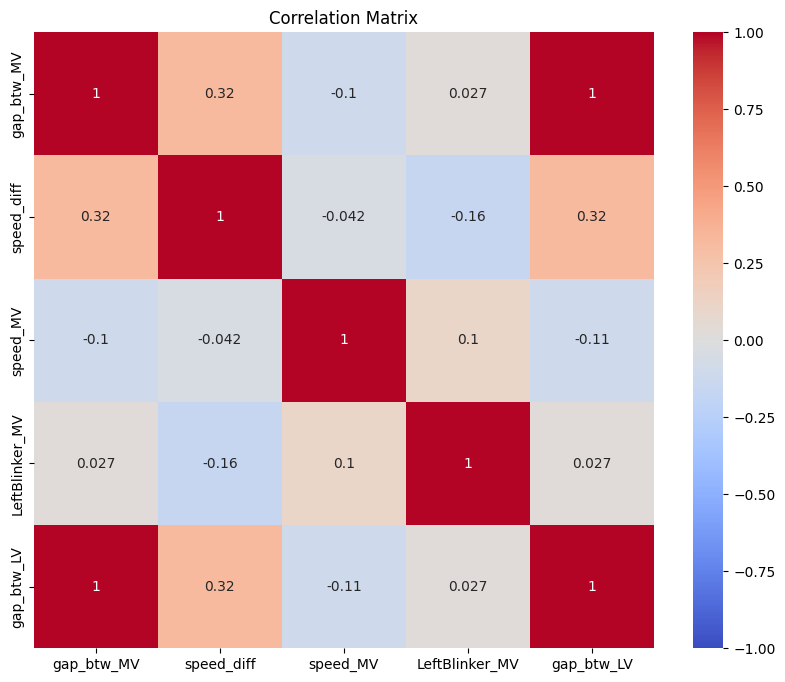

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# 상관관계 매트릭스 계산
correlation_matrix = X.corr()

# 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

In [12]:
## VIF describe
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df[['gap_btw_MV' ,'speed_diff', 'speed_MV' ,'LeftBlinker_MV']]
vif = pd.DataFrame()


vif["VIF Factor"]= [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif["features"]=X.columns
vif

,VIF Factor,features
0,9.280639,gap_btw_MV
1,7.062061,speed_diff
2,9.625891,speed_MV
3,2.116762,LeftBlinker_MV


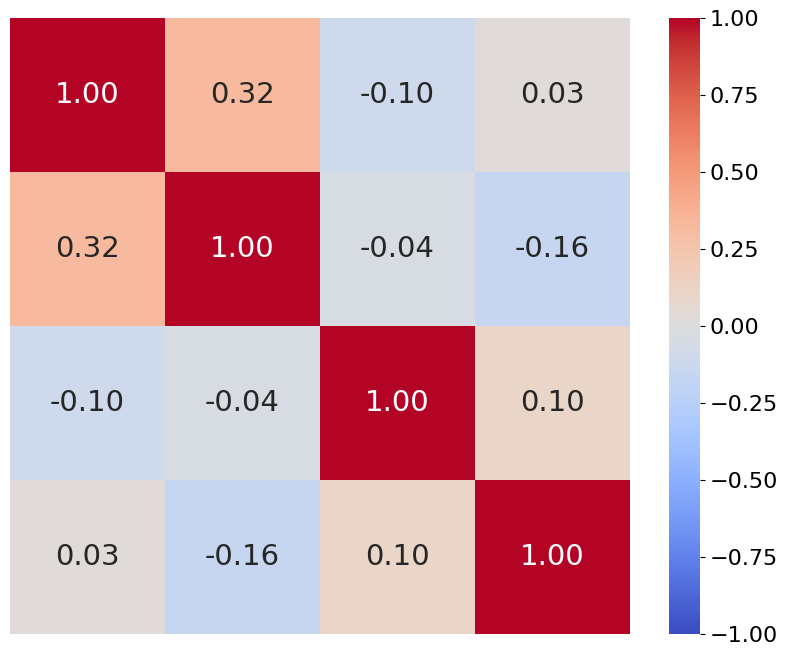

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# 상관관계 매트릭스 계산
correlation_matrix = X.corr()

# 히트맵 그리기
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(correlation_matrix, annot=True,annot_kws={"size": 21},fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, xticklabels=False, yticklabels=False)
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)  # 컬러 바 숫자 크기 설정
# plt.title('Correlation Matrix',)
plt.show()

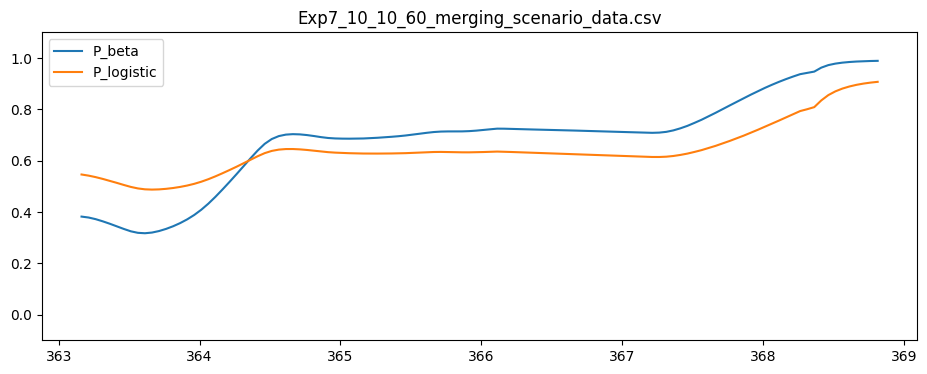

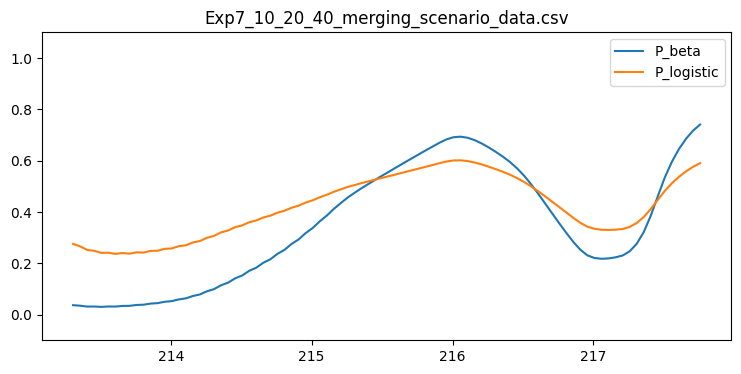

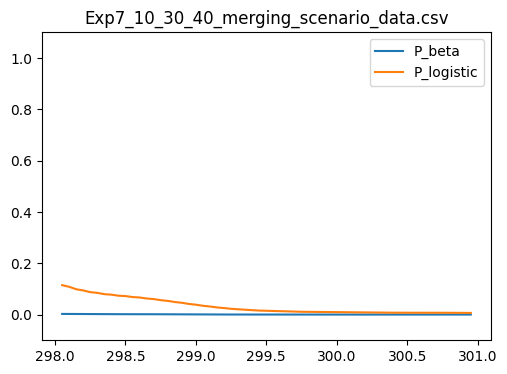

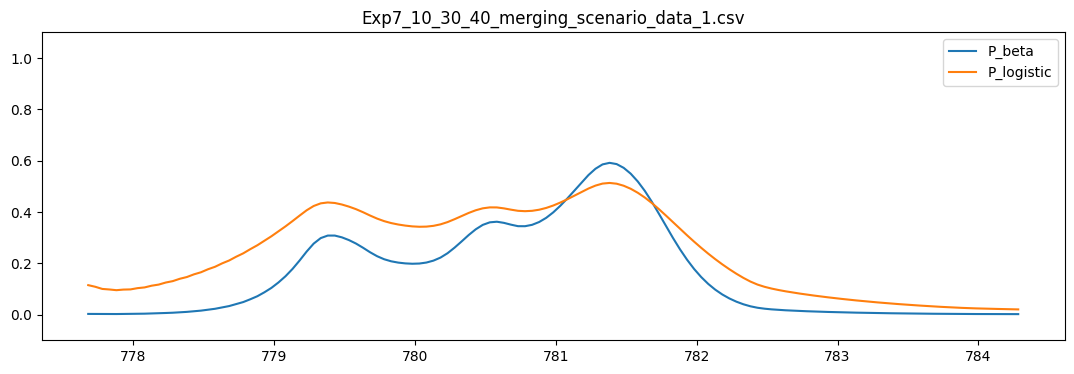

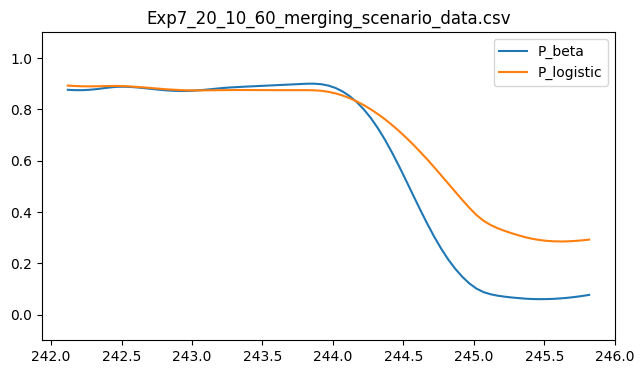

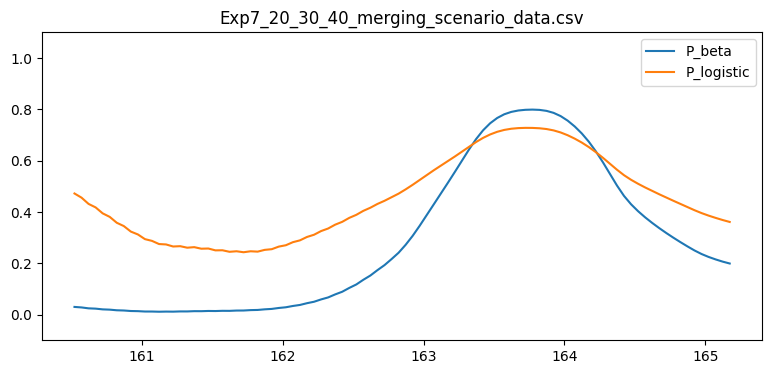

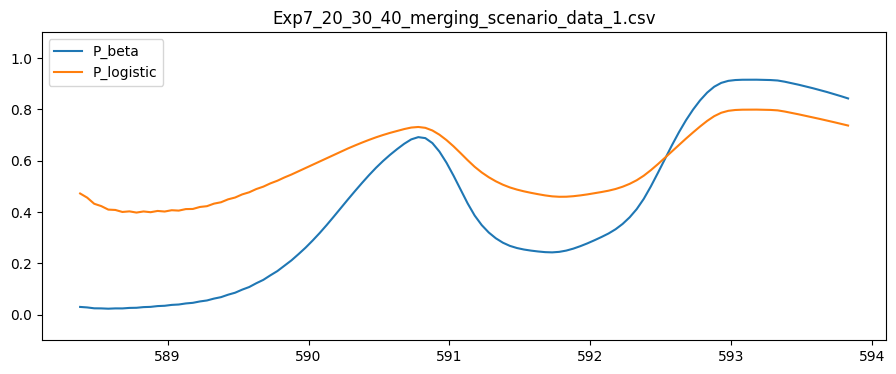

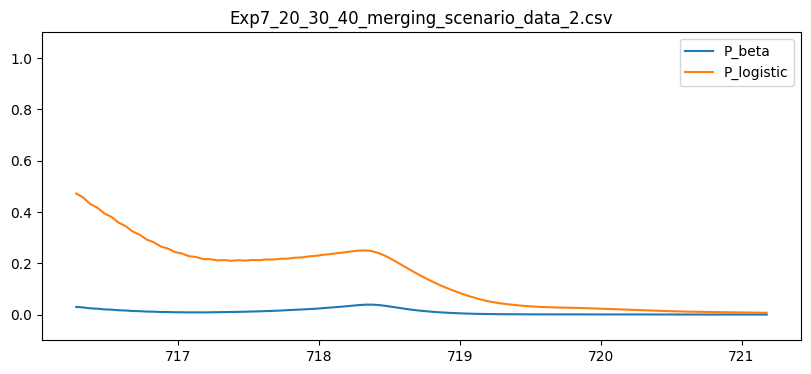

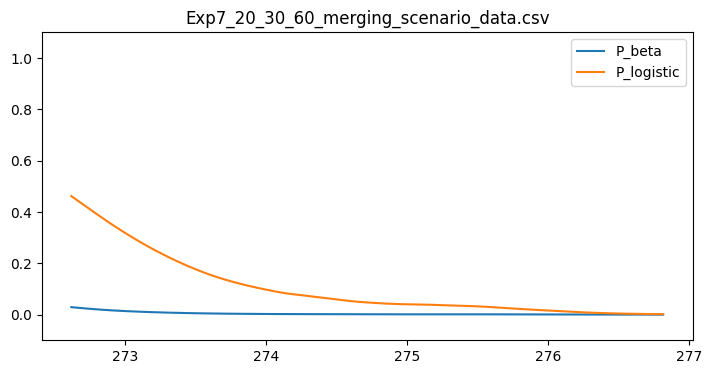

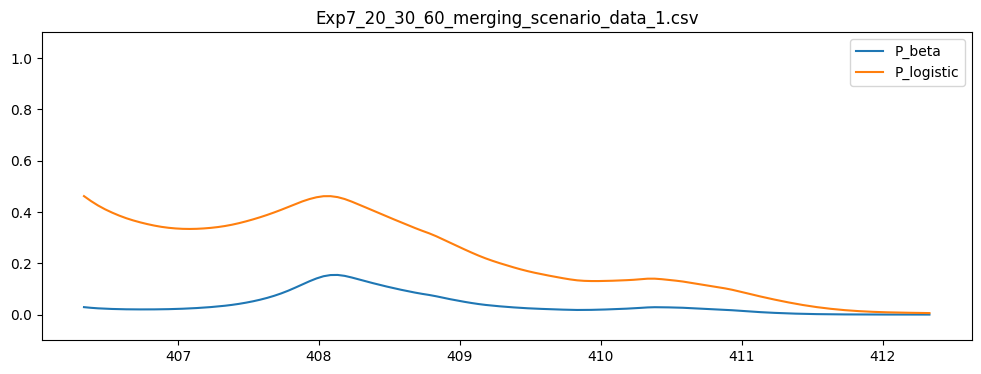

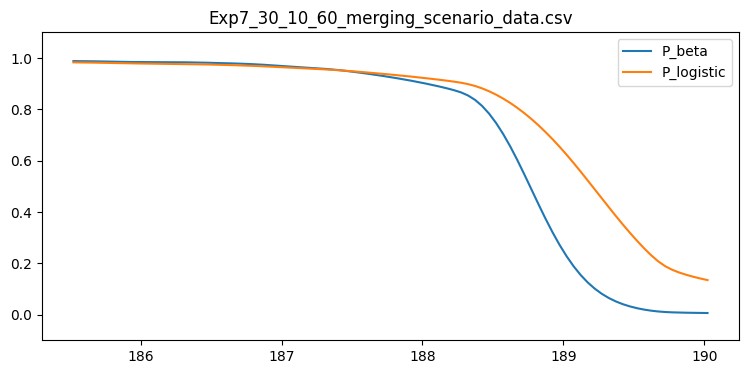

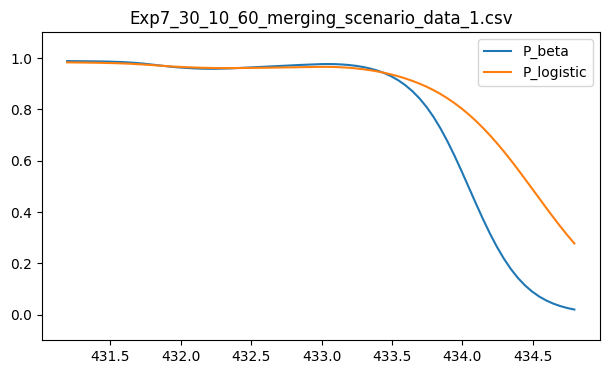

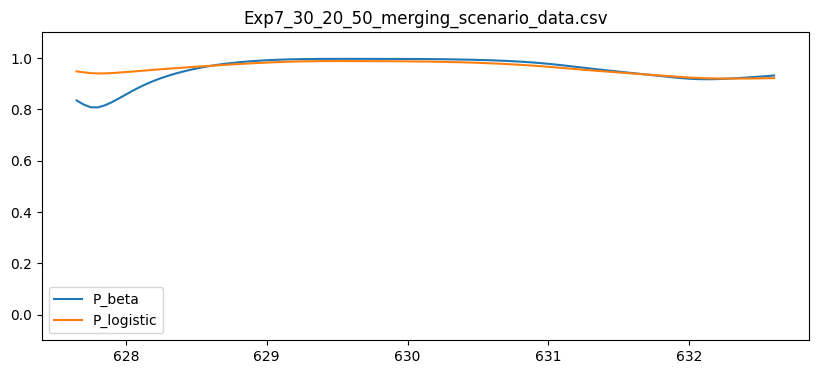

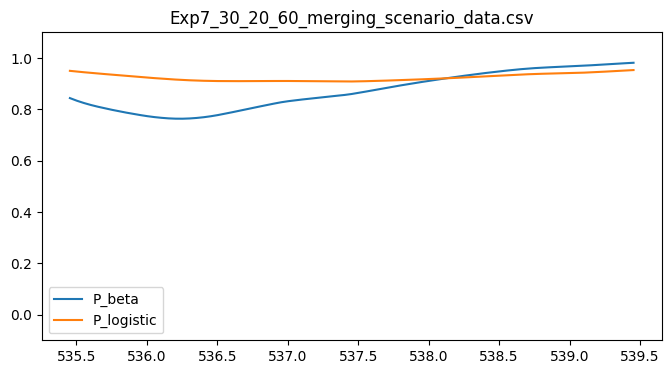

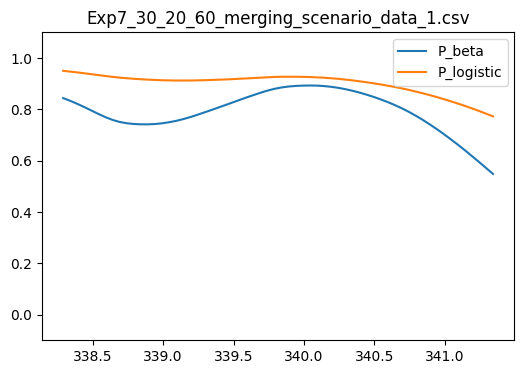

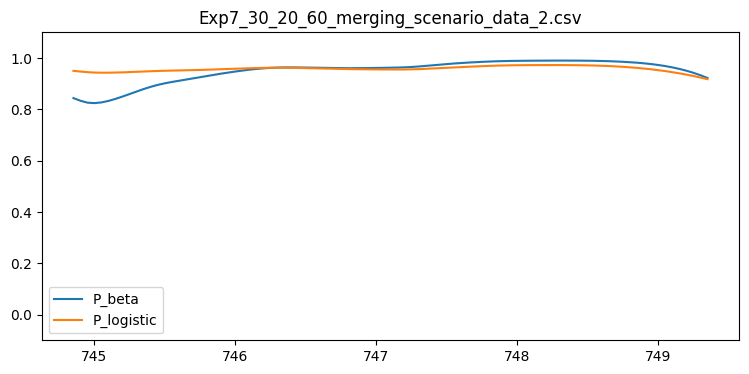

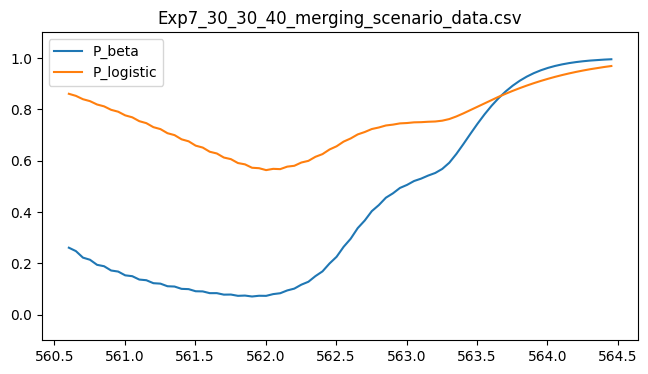

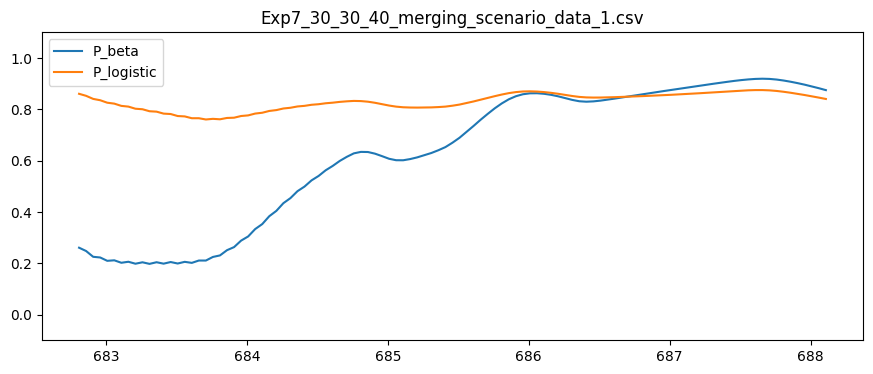

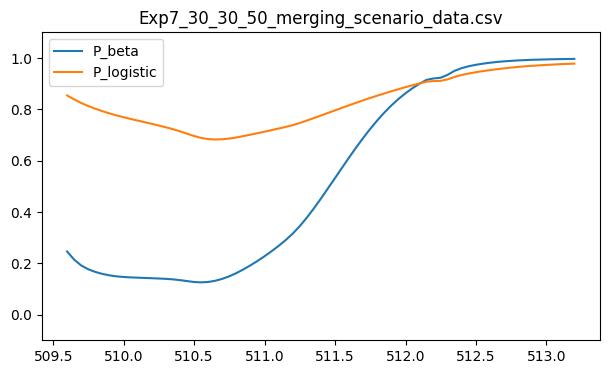

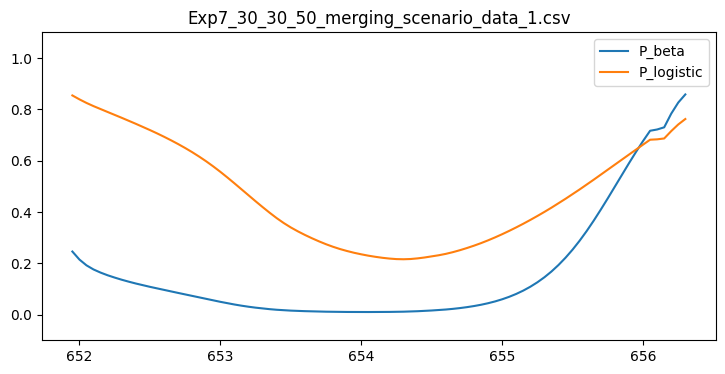

In [56]:
for i in range(7, 9):

    folder_path = Path('./DS_experiment_data/Exp'+str(i)+'/')
    csv_files = folder_path.glob('*.csv')

    for file_path in csv_files:
        ID = os.path.basename(file_path)
        # Initialize
        data = pd.DataFrame()

        data = pd.read_csv(file_path)
        data.loc[~((data['x_MV'] > 13.3) & (data['gap_btw_MV'] > -vehicle_length)), ['P_beta', 'P_logistic']] = np.nan
        
        plt.figure(figsize=((data['Time'][data['P_beta'].dropna().index[-1]]-data['Time'].loc[0])*2,4))
            
        plt.title(ID)
        # plt.xlim([data['Time'].iloc[0]-0.1,data['Time'].iloc[-1]+0.1])
        plt.ylim([-0.1, 1.1])
        plt.plot(data['Time'], data['P_beta'], label='P_beta')
        plt.plot(data['Time'], data['P_logistic'], label='P_logistic')
        plt.legend()

        # file_name = os.path.basename(file_path)
        # file_name = file_name.replace('.csv','')
        # print(file_name,'DONE')
    break

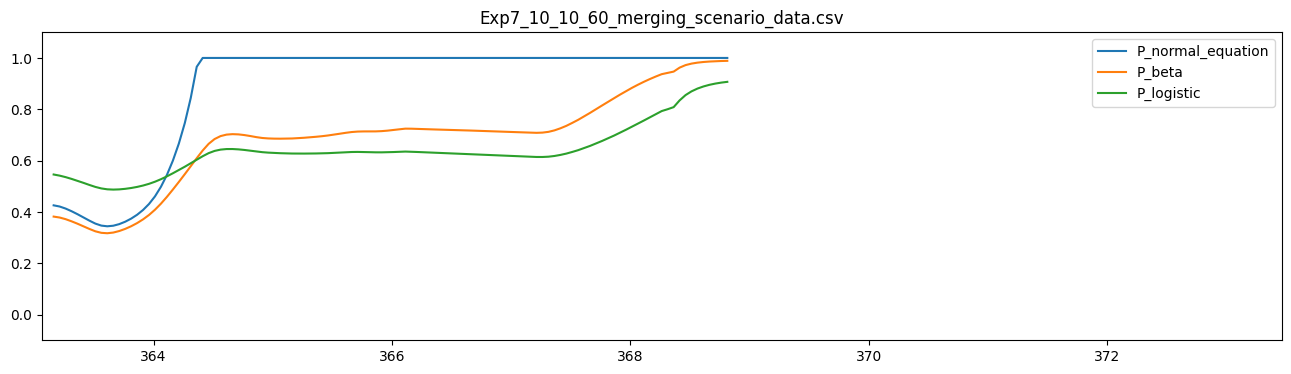

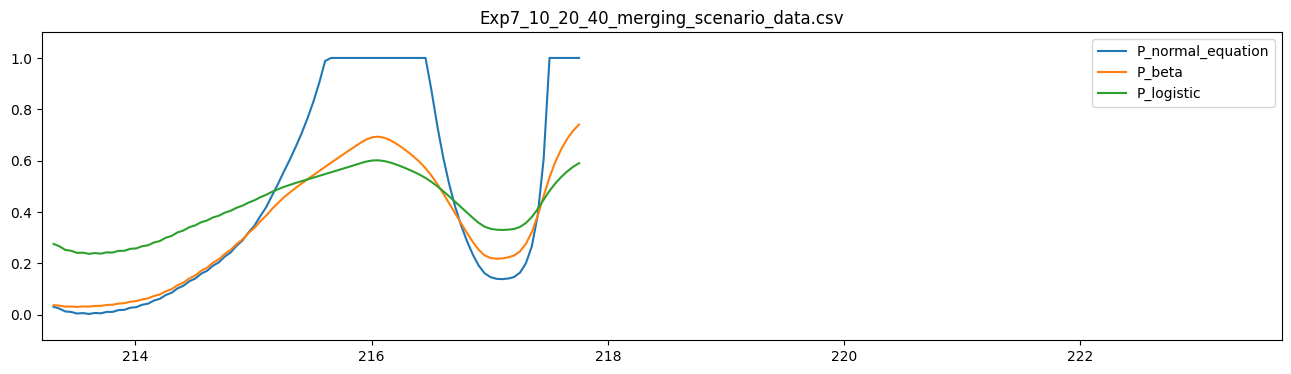

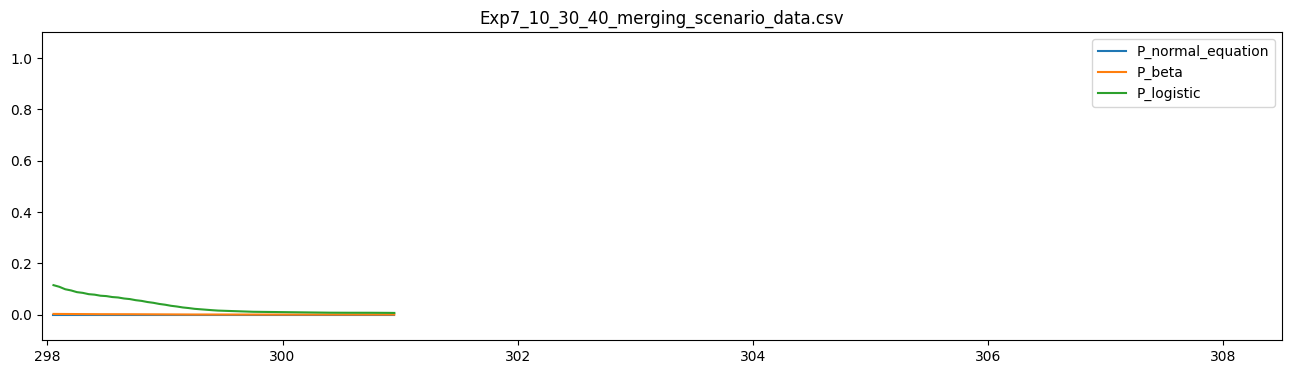

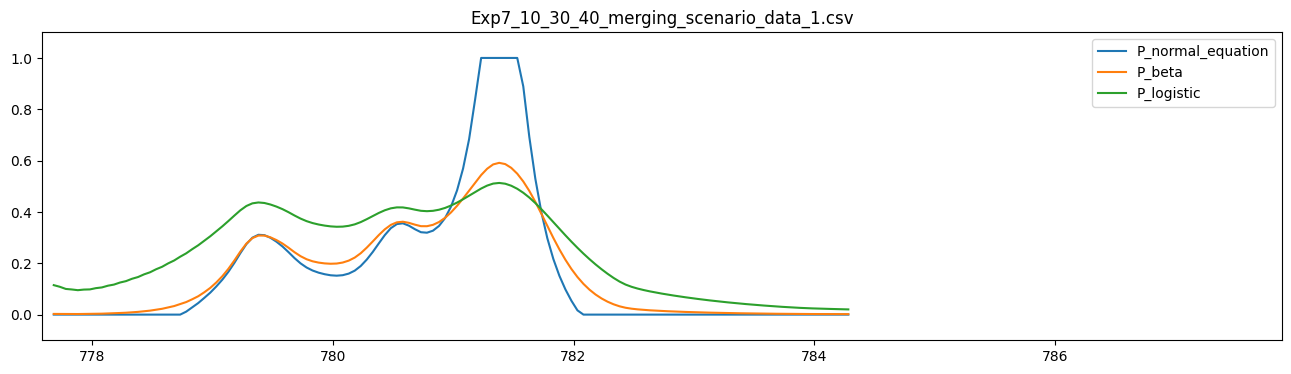

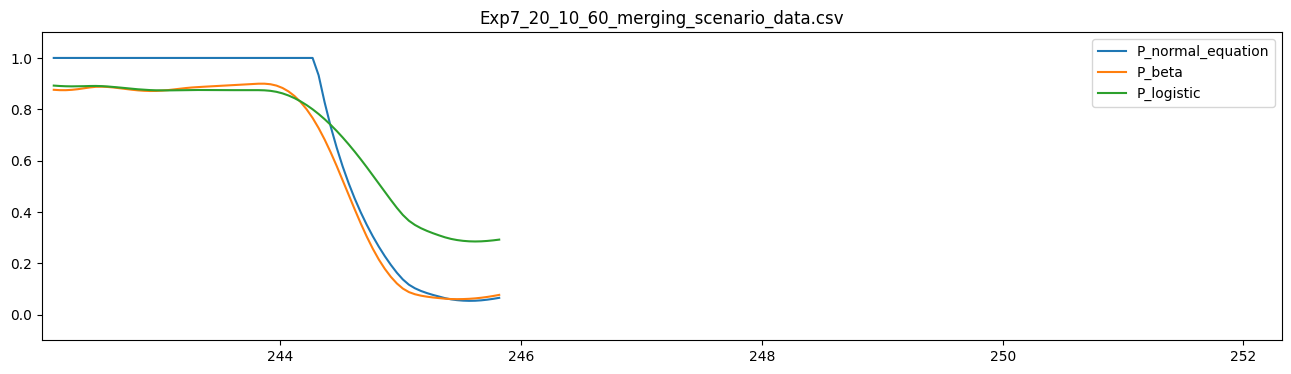

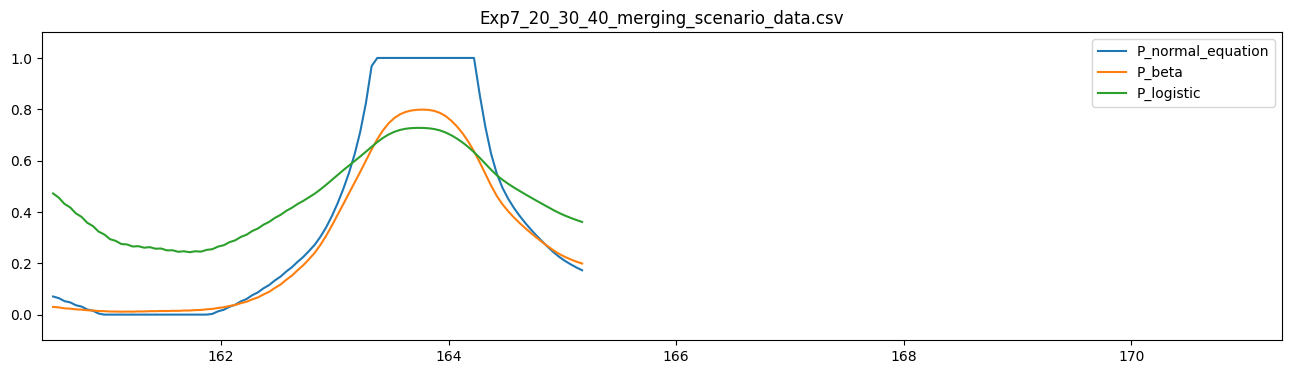

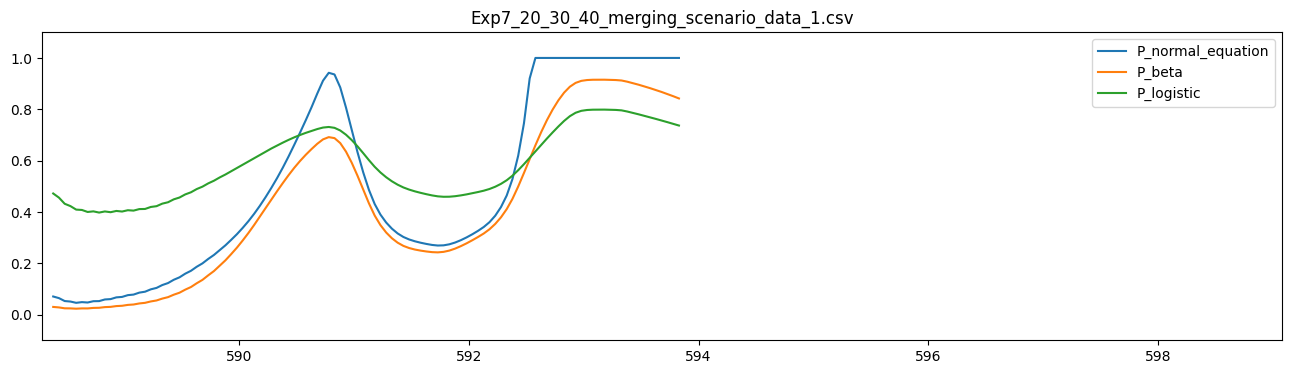

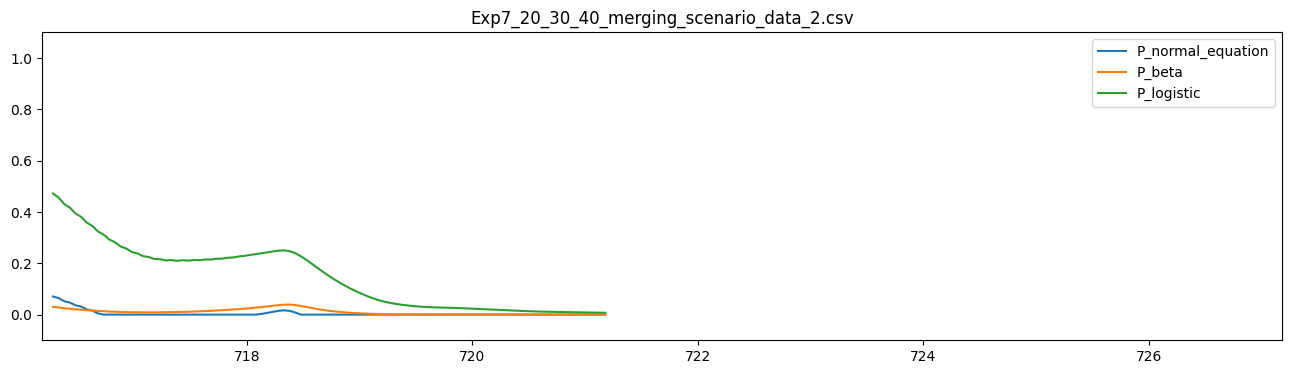

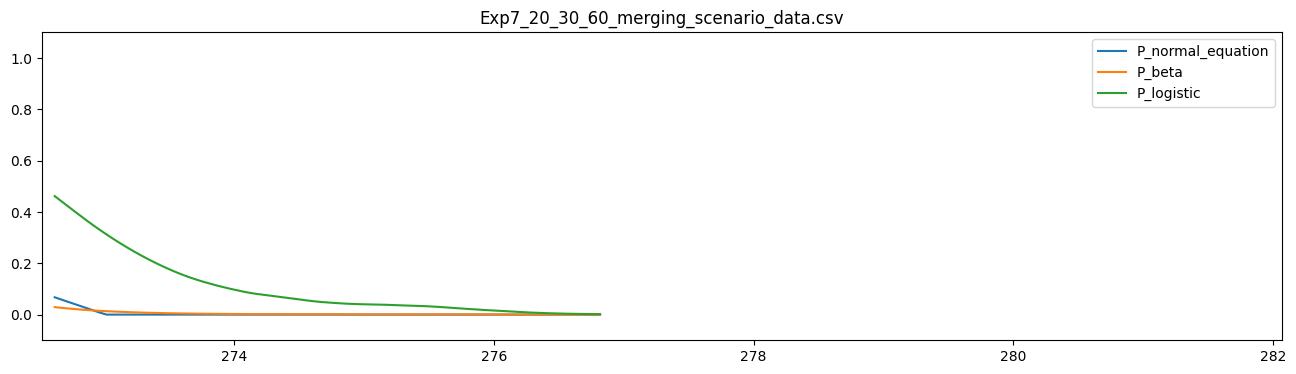

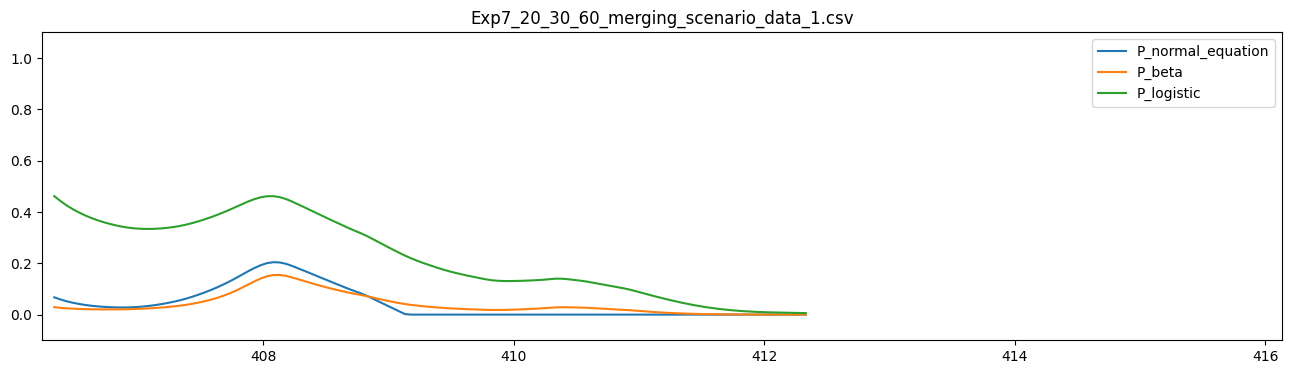

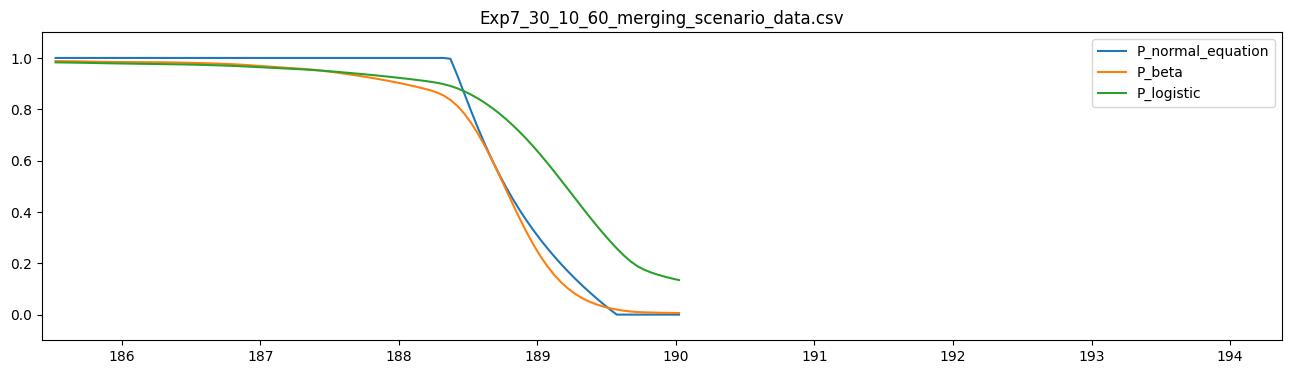

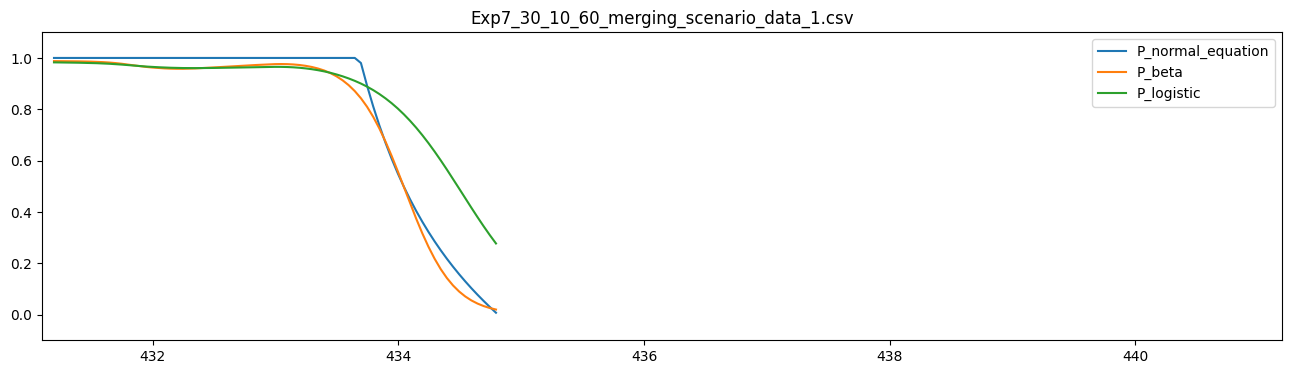

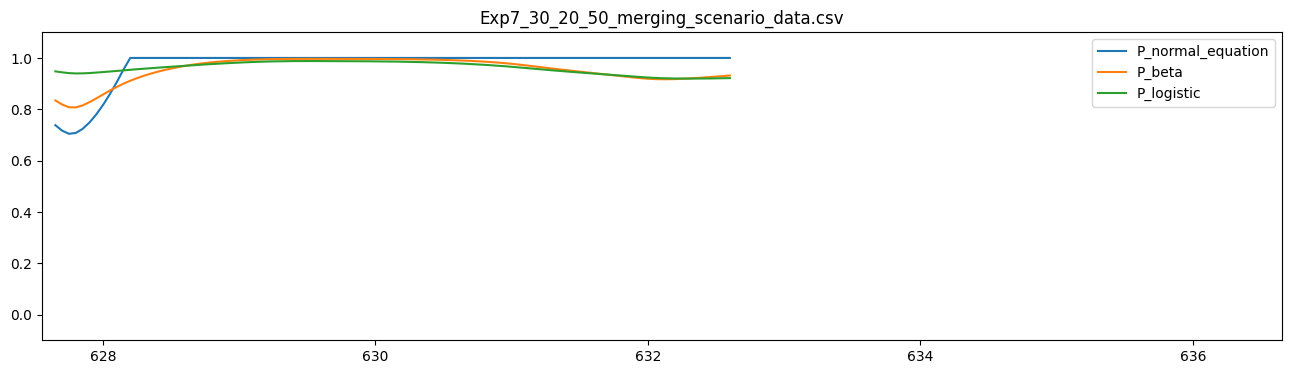

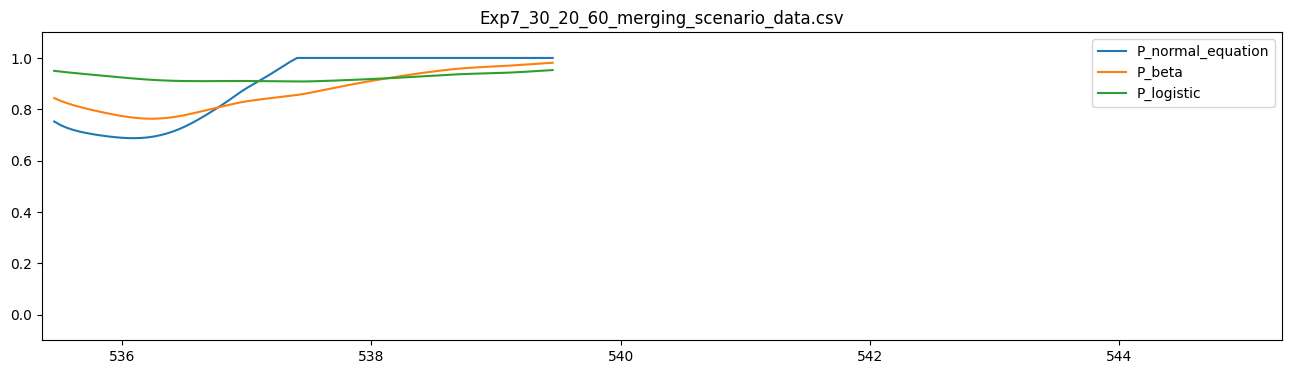

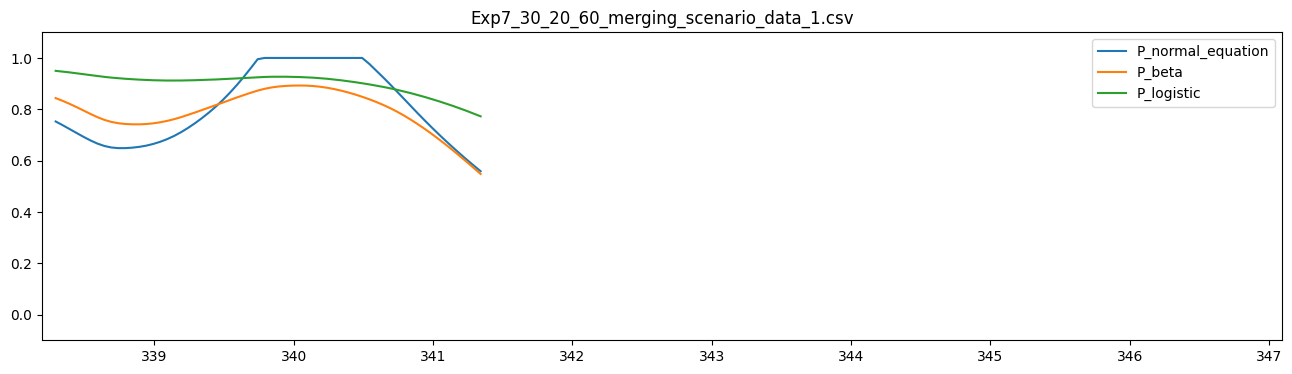

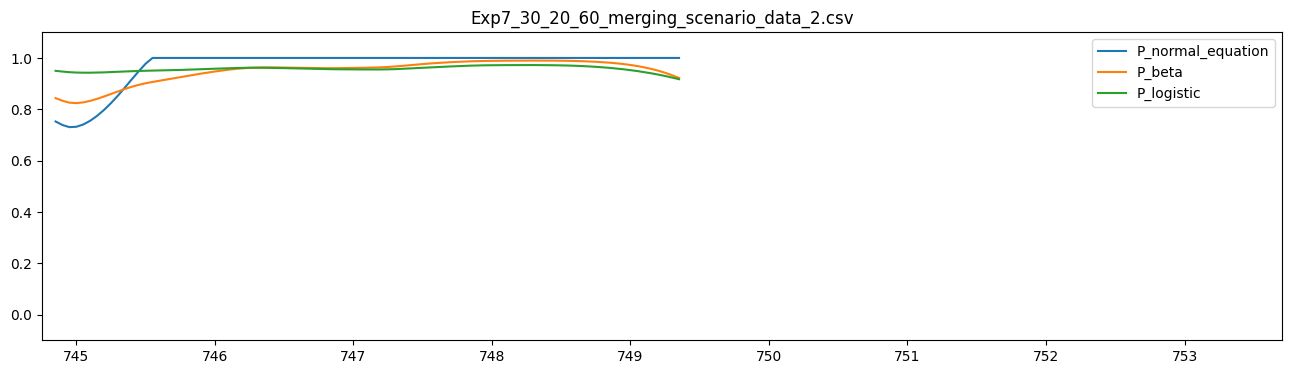

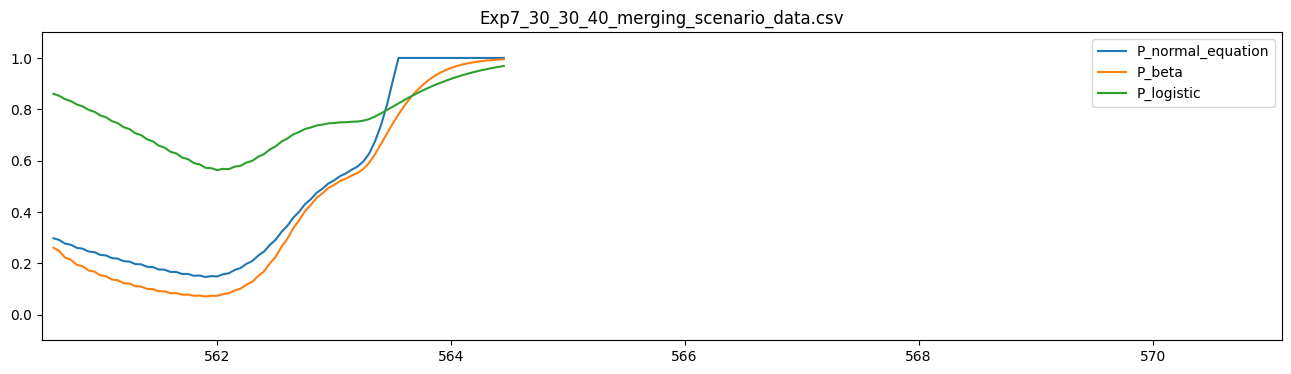

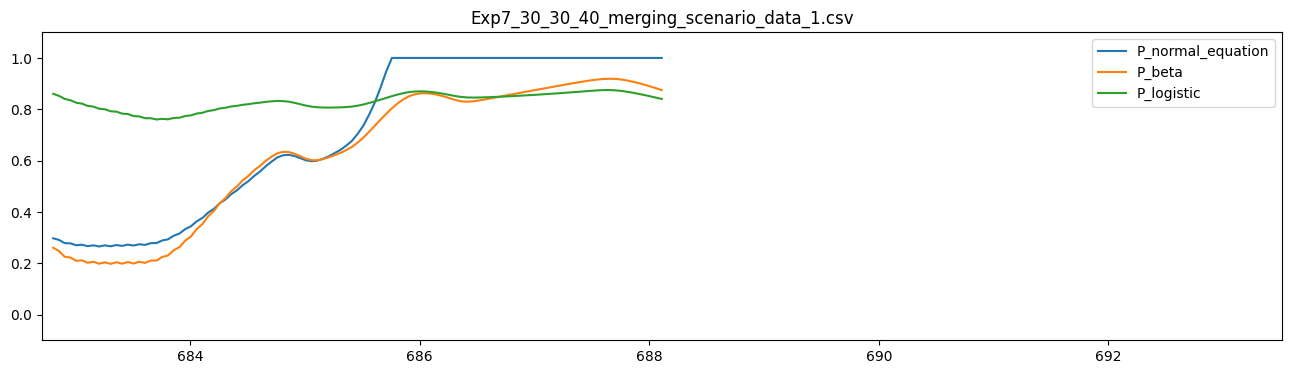

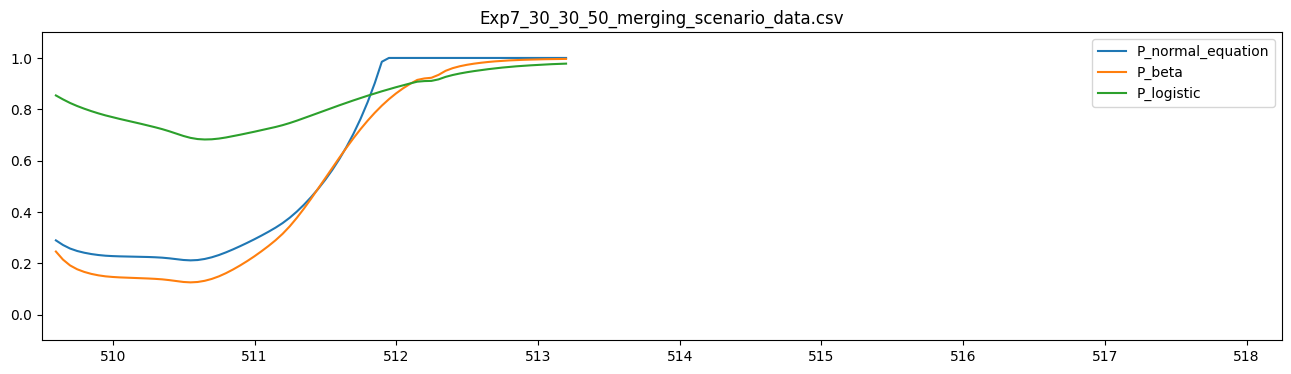

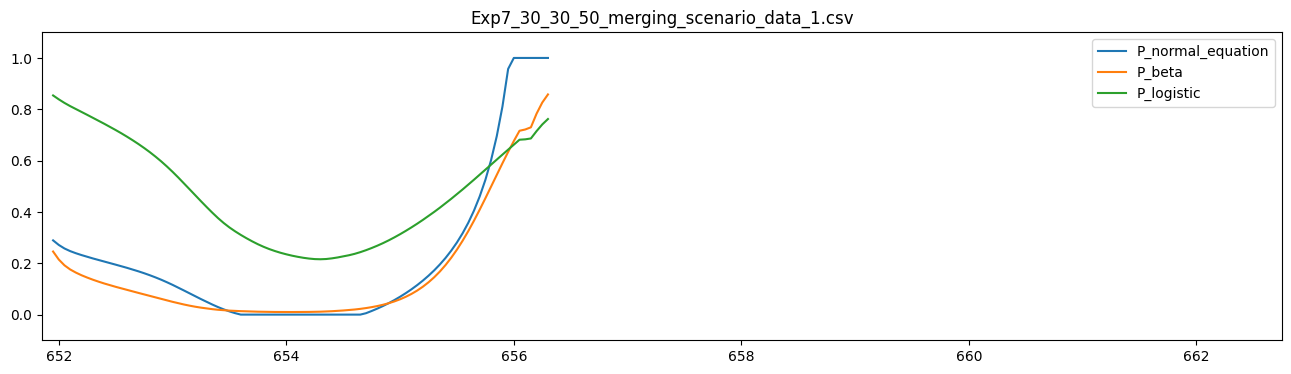

In [32]:
for i in range(7, 9):

    folder_path = Path('./DS_experiment_data/Exp'+str(i)+'/')
    csv_files = folder_path.glob('*.csv')

    for file_path in csv_files:
        ID = os.path.basename(file_path)
        # Initialize
        data = pd.DataFrame()

        data = pd.read_csv(file_path)
        data.loc[~((data['x_MV'] > 13.3) & (data['gap_btw_MV'] > -vehicle_length)), ['P_normal_equation', 'P_beta', 'P_logistic']] = np.nan
        plt.figure(figsize=(16,4))
            
        plt.title(ID)
        plt.xlim([data['Time'].iloc[0]-0.1,data['Time'].iloc[-1]+0.1])
        plt.ylim([-0.1, 1.1])
        plt.plot(data['Time'], data['P_normal_equation'], label='P_normal_equation')
        plt.plot(data['Time'], data['P_beta'], label='P_beta')
        plt.plot(data['Time'], data['P_logistic'], label='P_logistic')
        plt.legend()

        # file_name = os.path.basename(file_path)
        # file_name = file_name.replace('.csv','')
        # print(file_name,'DONE')
    break

In [2]:
for i in range(7, 9):

    folder_path = Path('./DS_experiment_data/Exp'+str(i)+'/')
    csv_files = folder_path.glob('*.csv')

    for file_path in csv_files:
        ID = os.path.basename(file_path)
        # Initialize
        data = pd.DataFrame()

        data = pd.read_csv(file_path)
        data['P_logistic_new'] = model.predict_proba(data[[ 'speed_diff', 'gap_btw_MV']])[:,1]
        data.loc[~((data['x_MV'] > 13.3) & (data['gap_btw_MV'] > -vehicle_length)), ['P_normal_equation', 'P_beta', 'P_logistic', 'P_logistic_new']] = np.nan
        plt.figure(figsize=(16,4))
            
        plt.title(ID)
        plt.xlim([data['Time'].iloc[0]-0.1,data['Time'].iloc[-1]+0.1])
        plt.ylim([-0.1, 1.1])
        # plt.plot(data['Time'], data['P_normal_equation'], label='P_normal_equation')
        plt.plot(data['Time'], data['P_beta'], label='P_beta')
        plt.plot(data['Time'], data['P_logistic_new'], label='P_logistic_new')
        plt.plot(data['Time'], data['P_logistic'], label='P_logistic')
        plt.legend()

        # file_name = os.path.basename(file_path)
        # file_name = file_name.replace('.csv','')
        # print(file_name,'DONE')
    break


NameError: name 'Path' is not defined

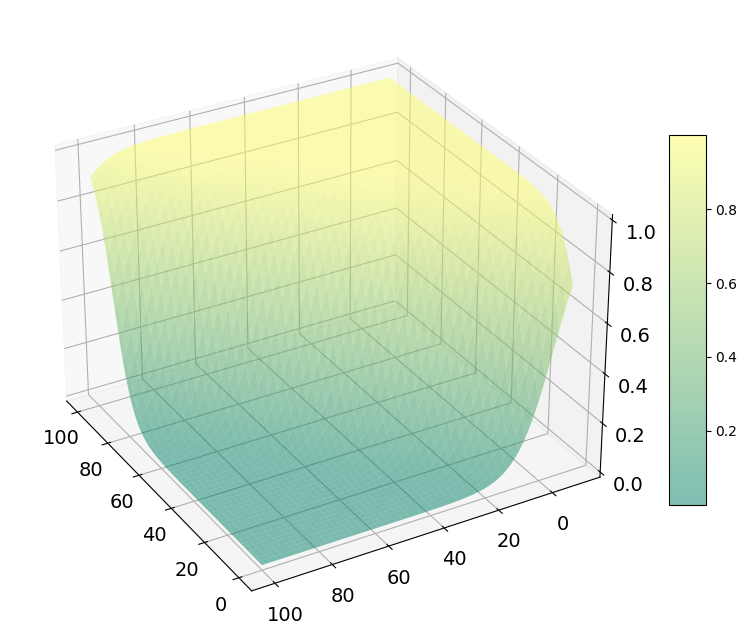

In [26]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.othermod.betareg import BetaModel
from statsmodels.genmod.families.links import logit
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle
with open('logit_model.pkl','rb') as file:
    logistic_model = pickle.load(file)


coeffi = logistic_model.params.values

# 격자 생성을 위한 distance와 speed_diff의 범위 정의
distance_range = np.linspace(0, 100, 100)
speed_diff_range = np.linspace(-10, 100, 100)

# 격자 생성
D, S = np.meshgrid(distance_range, speed_diff_range)
# TTC = D/S  # TTC 계산
X_grid = np.column_stack((np.ones(D.size), D.ravel(), S.ravel()))  # 상수 항 포함

# X_grid = np.column_stack((np.ones(D.size), TTC.ravel()))
# 모델을 사용하여 격자 위의 지점들에 대한 p 예측
p_predicted = logistic_model.predict(X_grid)
p_predicted = p_predicted.reshape(D.shape)

# print(logistic_model.summary())

# 3D 그래프 준비
fig = plt.figure(figsize=(10, 16))
ax = fig.add_subplot(111, projection='3d')

test_set = [(20,10),(20,40),(30,40),(30,20),(30,30),(40,30),(-5,5)]
# for i in test_set:
#     print(logistic_model.predict(np.column_stack((np.ones(1), i[0], i[1]/3.6)))[0])
#     print(1/(1+math.exp(-(coeffi[0]+coeffi[1]*i[0]+coeffi[2]*i[1]/3.6))))
#     print()
#     # print('(X,Y)=(%dm, %dkm/h)=%2.5f'%(*i, results.predict(1, i[0], i[1]/3.6)))

# 예측된 p 값을 사용하여 3D 플롯 그리기
# 예측된 p 값을 사용하여 3D 플롯 그리기
surf = ax.plot_surface(D, S, p_predicted, cmap='summer', alpha=0.5)
# ax.plot_surface(D, S, p_predicted,  cmap='summer', alpha=0.5)
# plt.title('Interaction probability $\mu$',fontsize = 15)
# ax.set_xlabel('$X_{1}$: Follow gap [m]',fontsize = 20)
# ax.set_ylabel('$X_{2}$: Speed difference [km/h]',fontsize = 20)
# ax.set_zlabel("$\mu$ : Merging probability",fontsize = 20, rotation=90)
ax.set_zlim([0.0, 1.0])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.tick_params(axis='z', labelsize=14)

fig.colorbar(surf, shrink=0.3, aspect=10)  # 색상 막대 추가
ax.view_init(elev=30, azim=150)
# plt.tight_layout()
plt.show()

